In [14]:
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns

from matplotlib import pyplot as plt
import seaborn as sns

### Construct a Pandas dataframe of the data and target

In [15]:
df = sns.load_dataset('titanic')

df.drop(columns= ['embarked', 'class', 'who', 'adult_male', 'deck', 'alive'], 
        inplace= True)
df.rename(columns= {'survived':'target'}, inplace= True)

df['age'] = df.groupby(['pclass'])['age'].apply(lambda x: x.fillna(x.median()))
df = pd.get_dummies(data= df, columns= ['sex', 'alone', 'embark_town'], prefix= ['sex', 'alone', 'embark_town'], drop_first= True)

/var/folders/sf/lh5vs79n7sg9l5kff8g_h9zm0000gn/T/ipykernel_37091/3641064618.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['age'] = df.groupby(['pclass'])['age'].apply(lambda x: x.fillna(x.median()))


### Show features for dataframe

In [16]:
df.columns

Index(['target', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male',
       'alone_True', 'embark_town_Queenstown', 'embark_town_Southampton'],
      dtype='object')

# Construct Classifier with Single Predictor

In [17]:
feature_interest = 'age'

### Construct dataframe

In [18]:
df_1feature = df[[feature_interest, 'target']].copy()

In [19]:
df_1feature.sort_values(by= feature_interest, inplace= True)

### Solve explicitly

In [20]:
def calculate_impurity(x, method= 'entropy'):
    p = x.target.value_counts(normalize= True)
    
    if method == 'gini':
        return(1 - (p ** 2).sum())
    elif method == 'entropy':
        return(-(p * np.log(p)).sum())


def find_optimal_cutpoint(df_in):
    '''
    Calculates optimal split point for decission tree classifier.
    Prints impurity for parent and children nodes to screen
    
    Input: 
        df_in: Dataframe with features and target values for node to be calculated      
    Output:
        optimal_feature: The feature that produces the minimum total cost at a node. 
        optimal_cut: For the optimal feature, the best split point from maximizing the total cost 
        left_val: After splitting on optimal cut, the average value of instances within left (less than) node
        right_val:  After splitting on optimal cut, the mode value of instances within right (equal to, or greater than) node
        optimal_feature:
    '''
    
    optimal_by_feature = {}
    change_impurities = {}
    for feat in list(df_in.columns.drop('target')):
        ## Sort values by feature
        temp_df = df_in[[feat, 'target']].sort_values(by= feat)
        
        cutpoints = []
        LT_impurity = []
        GTE_impurity = []
        
        
        feat_unique_values = np.sort(temp_df[feat].unique())
        
        if feat_unique_values.shape[0] == 1:
            change_impurity = np.array([0])
            cutpoints.append(feat_unique_values[0])
            
        else:
            for i in np.arange(0, feat_unique_values.shape[0] - 1, 1):
                cutpoint = feat_unique_values[i:i+2].mean()
                cutpoints.append(cutpoint)

                LT = temp_df[temp_df[feat] < cutpoint]
                LT_impurity.append(
                    (LT.shape[0] / temp_df.shape[0]) * calculate_impurity(x= LT)
                )

                GTE = temp_df[temp_df[feat] >= cutpoint]
                GTE_impurity.append(
                    (GTE.shape[0] / temp_df.shape[0]) * calculate_impurity(x= GTE)
                )

                change_impurity = calculate_impurity(x= temp_df) - (np.array(LT_impurity) + np.array(GTE_impurity))

        optimal_by_feature[feat] = {'change_impurity':change_impurity[change_impurity.argmax()], 
                                    'cutpoint':cutpoints[change_impurity.argmax()]}
        
        change_impurities[feat] = ({'data': pd.DataFrame({'cutpoint':cutpoints,
                                                          'change_impurity':change_impurity}),
                                    'opt_cutpoint':cutpoints[change_impurity.argmax()]
                                   })
        
    opt_cost_by_feature = pd.DataFrame(optimal_by_feature, dtype= 'float')
    opt_feature = opt_cost_by_feature.loc['change_impurity'].idxmax()
    opt_cut = opt_cost_by_feature[opt_feature]['cutpoint']
    
    
    
    print(f'Parent Node Impurity: {calculate_impurity(x= df_in)}')
    print(f'Parent Node Size (N_t): {df_in.shape[0]}')
    print(f'\nOptimal Separation with feature {opt_feature} and cut point {opt_cut}')
    left_df = df_in[df_in[opt_feature] < opt_cut]
    left_val = left_df.target.mode()
    print(f'Left Node Size (N_l): {left_df.shape[0]}')
    print(f'Left Node Impurity: {calculate_impurity(x= left_df)}')

    right_df = df_in[df_in[opt_feature] > opt_cut]
    right_val = right_df.target.mode()
    print(f'Right Node Size (N_r): {right_df.shape[0]}')
    print(f'Right Node Impurity: {calculate_impurity(x= right_df)}')
    
    N_t = df_in.shape[0]
    N_t_l = left_df.shape[0]
    N_t_r = right_df.shape[0]
    
    feature_importance = np.array([opt_feature, float(N_t * (calculate_impurity(x= df_in) - \
                                      (N_t_l/N_t)*calculate_impurity(x= left_df) - \
                                      (N_t_r/N_t)*calculate_impurity(x= right_df)))])

    return(opt_feature, opt_cut, left_val, right_val, change_impurities, feature_importance)


## Intital Cut Point

In [21]:
root_feature, root_cut, root_left_avg, root_right_avg, root_total_cost_by_feature, _ = \
find_optimal_cutpoint(df_1feature)

Parent Node Impurity: 0.6659119735267652
Parent Node Size (N_t): 891

Optimal Separation with feature age and cut point 6.5
Left Node Size (N_l): 47
Left Node Impurity: 0.6090507476035167
Right Node Size (N_r): 844
Right Node Impurity: 0.6568549067395983


### Show root node total cost and position of optimal cut

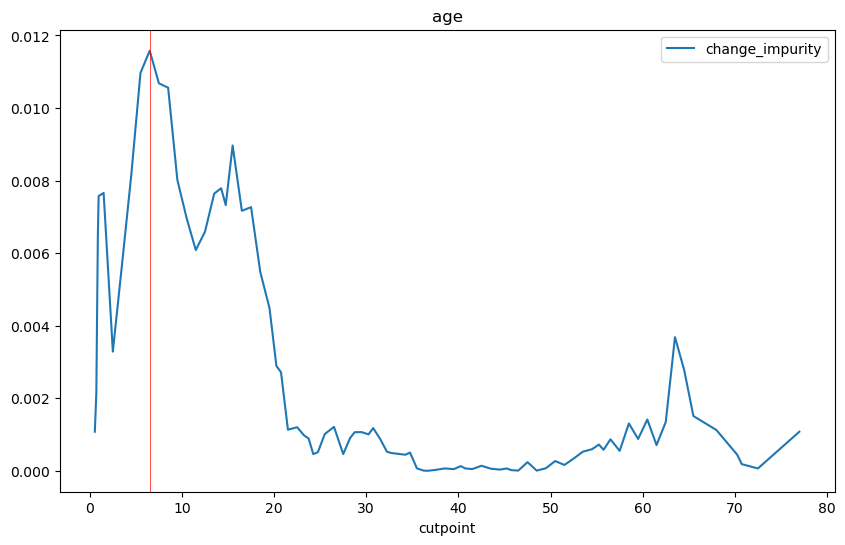

In [22]:
for feat in root_total_cost_by_feature.keys():
    ax = root_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'change_impurity', figsize= (10, 6))
    ax.axvline(x= root_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    ax.set_title(feat)

### Root node cutpoint
* Plot Target value versus feature value (blue)
* Black line was initial root node cutpoint
* If the tree was only depth of one, the values predicted would the red dashed lines between the vertical line and data bounds

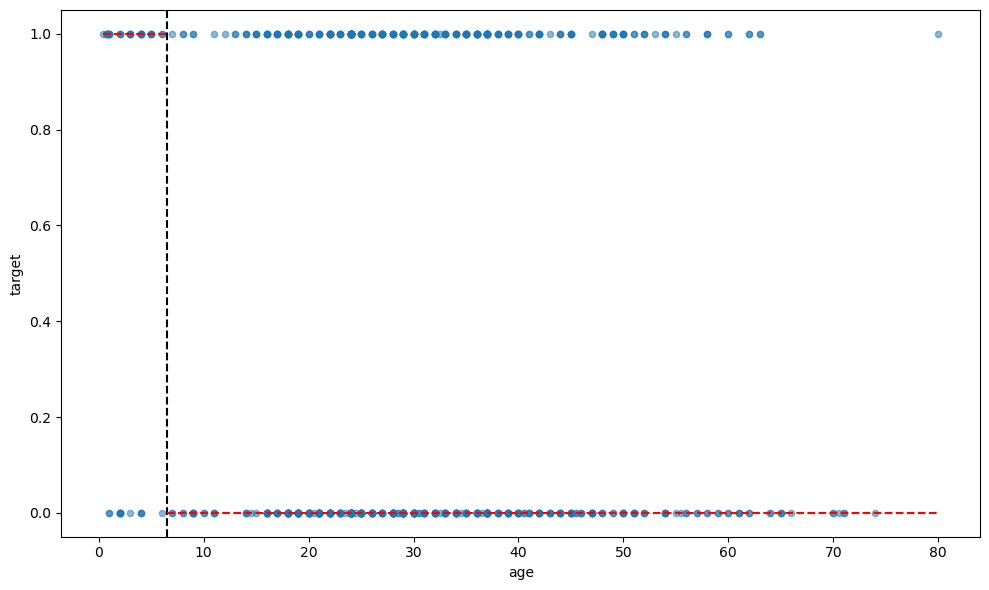

In [23]:
fig, ax = plt.subplots(figsize= (10, 6))
df_1feature.plot.scatter(x= feature_interest, y= 'target', ax= ax, zorder= 1, alpha= 0.5)
plt.axvline(x = root_cut, c= 'black', linestyle= '--')
ax.hlines(y = root_left_avg, 
          xmin= df_1feature[feature_interest].min(), 
          xmax= root_cut, 
          color= 'red', linestyle= '--',)
ax.hlines(y = root_right_avg, 
          xmin= root_cut, 
          xmax= df_1feature[feature_interest].max(), 
          color= 'red', linestyle= '--')
plt.tight_layout()
plt.show()

## Second cut points

### Left Child Node
* Training data frame is filtered to include only those instances that are less than the initial cutpoint

In [24]:
left_feature, left_cut, left_left_avg, left_right_avg, left_total_cost_by_feature, _ = \
find_optimal_cutpoint(df_1feature[df_1feature[feature_interest] < root_cut])

Parent Node Impurity: 0.6090507476035167
Parent Node Size (N_t): 47

Optimal Separation with feature age and cut point 0.96
Left Node Size (N_l): 7
Left Node Impurity: -0.0
Right Node Size (N_r): 40
Right Node Impurity: 0.6474466390346325


### Show left child node total cost and position of optimal cut

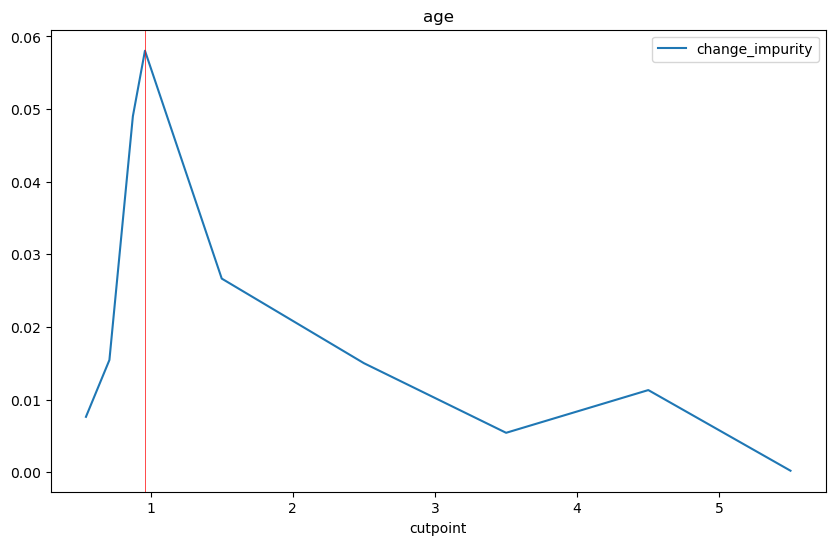

In [26]:
for feat in left_total_cost_by_feature.keys():
    ax = left_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'change_impurity', figsize= (10, 6))
    ax.axvline(x= left_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    ax.set_title(feat)

### Right Child Node
* Training data frame is filtered to include only those instances that are equal to, or greater than than the initial cutpoint

In [27]:
right_feature, right_cut, right_left_avg, right_right_avg, right_total_cost_by_feature, _ = \
find_optimal_cutpoint(df_1feature[df_1feature[feature_interest] >= root_cut])

Parent Node Impurity: 0.6568549067395983
Parent Node Size (N_t): 844

Optimal Separation with feature age and cut point 26.5
Left Node Size (N_l): 408
Left Node Impurity: 0.6276796779501332
Right Node Size (N_r): 436
Right Node Impurity: 0.6762178285284645


### Show left child node total cost and position of optimal cut

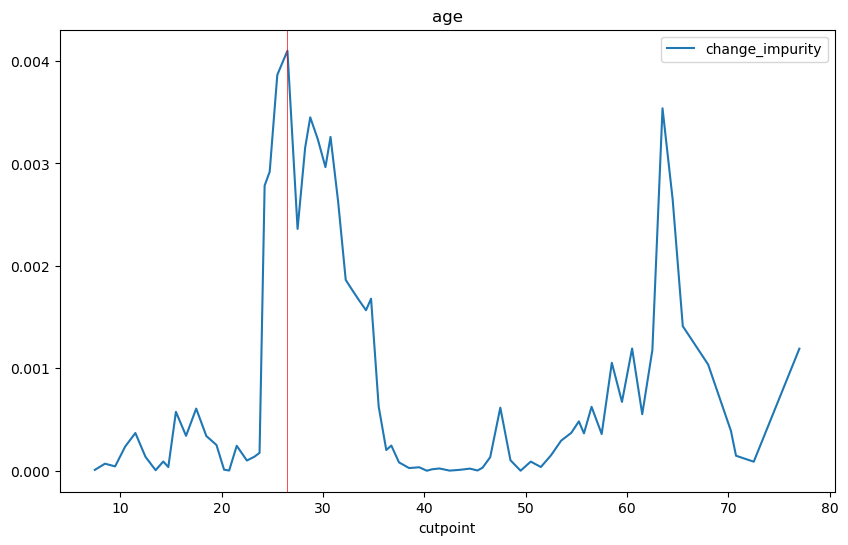

In [29]:
for feat in right_total_cost_by_feature.keys():
    ax = right_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'change_impurity', figsize= (10, 6))
    ax.axvline(x= right_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    ax.set_title(feat)

### Root node and children node cut points
* Plot Target value versus feature value (blue)
* Verical lines represent best found cutpoints
    * Dotted line was initial root node cutpoint
    * Solid lines are cutpoints found from left and right children nodes
* If the tree was only depth of two, the values predicted would the dashed horizontal line between the verticals or data bounds

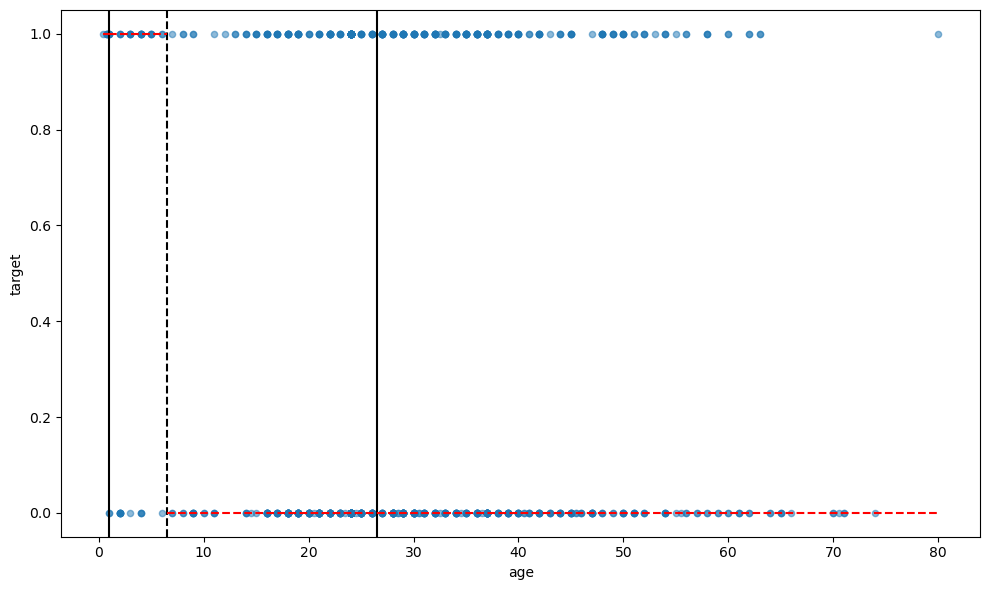

In [30]:
fig, ax = plt.subplots(figsize= (10, 6))
df_1feature.plot.scatter(x= feature_interest, y= 'target', ax= ax, zorder= 1, alpha= 0.5)
plt.axvline(x = root_cut, c= 'black', linestyle= '--')
plt.axvline(x = left_cut, c= 'black')
plt.axvline(x = right_cut, c= 'black')
ax.hlines(y = left_left_avg, xmin= df_1feature[feature_interest].min(), xmax= left_cut, 
          color= 'red', linestyle= '--',)
ax.hlines(y = left_right_avg, xmin= left_cut, xmax= root_cut, 
          color= 'red', linestyle= '--')
ax.hlines(y = right_left_avg, xmin= root_cut, xmax= right_cut, 
          color= 'red', linestyle= '--',)
ax.hlines(y = right_right_avg, xmin= right_cut, xmax= df_1feature[feature_interest].max(), 
          color= 'red', linestyle= '--')
plt.tight_layout()
plt.show()

### Explicitly calculate cut points

In [31]:
print(root_feature, root_cut)
print(left_feature, left_cut)
print(right_feature, right_cut)

age 6.5
age 0.96
age 26.5


### Comparison to SKLearn's tree

In [32]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier(max_depth= 2, criterion= 'entropy')
dec_tree.fit(X= np.array(df_1feature[feature_interest]).reshape(-1, 1), 
             y= df_1feature.target)

sklearn_tree_detail= \
pd.DataFrame({'feature_label':dec_tree.tree_.feature,
              'feature':feature_interest,
              'cutpoint':dec_tree.tree_.threshold
             })


sklearn_tree_detail['feature'] = \
np.where(sklearn_tree_detail.feature_label == -2, 'LEAF', sklearn_tree_detail.feature)
sklearn_tree_detail['cutpoint'] = \
np.where(sklearn_tree_detail.feature_label == -2, np.nan, sklearn_tree_detail.cutpoint)

sklearn_tree_detail

,feature_label,feature,cutpoint
0,0,age,6.50
1,0,age,0.96
2,-2,LEAF,NaN
3,-2,LEAF,NaN
4,0,age,26.50
5,-2,LEAF,NaN
6,-2,LEAF,NaN


# Construct Classifier with Multiple Features

In [33]:
df.columns

Index(['target', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male',
       'alone_True', 'embark_town_Queenstown', 'embark_town_Southampton'],
      dtype='object')

In [34]:
features_interest = ['age', 'sex_male', 'sibsp', 'parch', 'fare']

In [35]:
df_multiplefeatures = df[features_interest + ['target']].copy()

In [36]:
root_feature, root_cut, root_left_avg, root_right_avg, root_total_cost_by_feature, root_fi = \
find_optimal_cutpoint(df_in= df_multiplefeatures)

Parent Node Impurity: 0.6659119735267652
Parent Node Size (N_t): 891

Optimal Separation with feature sex_male and cut point 0.5
Left Node Size (N_l): 314
Left Node Impurity: 0.5709141922481396
Right Node Size (N_r): 577
Right Node Impurity: 0.4846358858279689


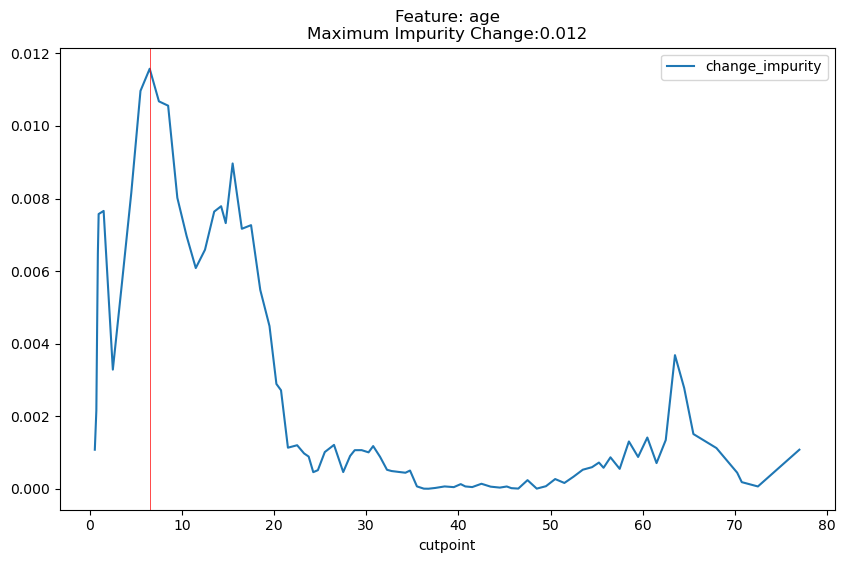

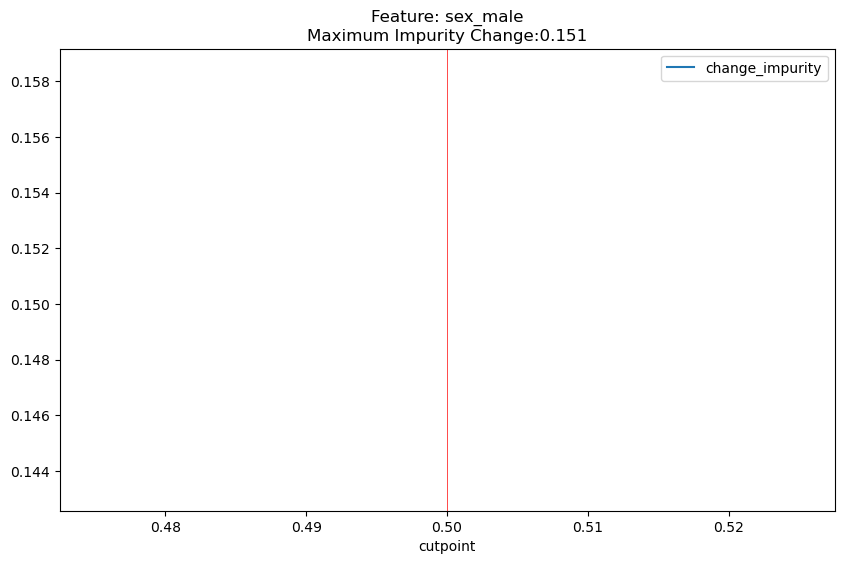

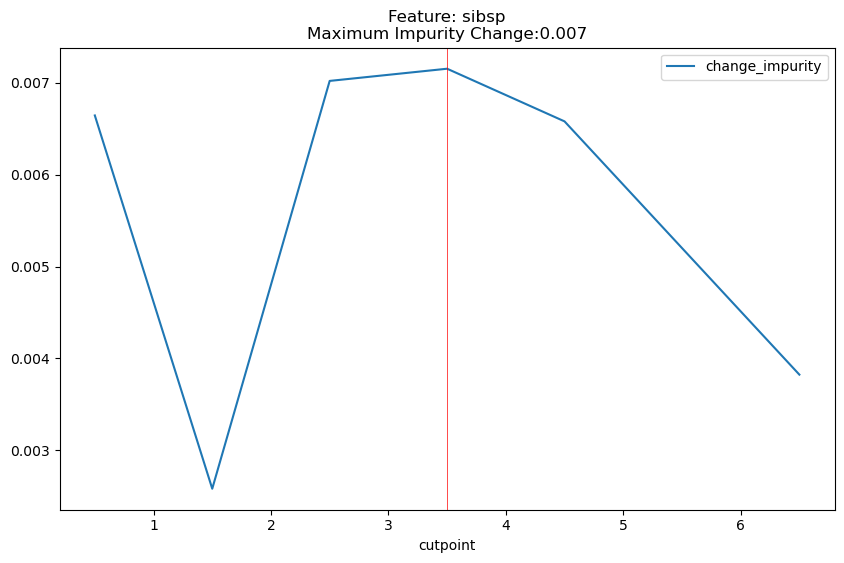

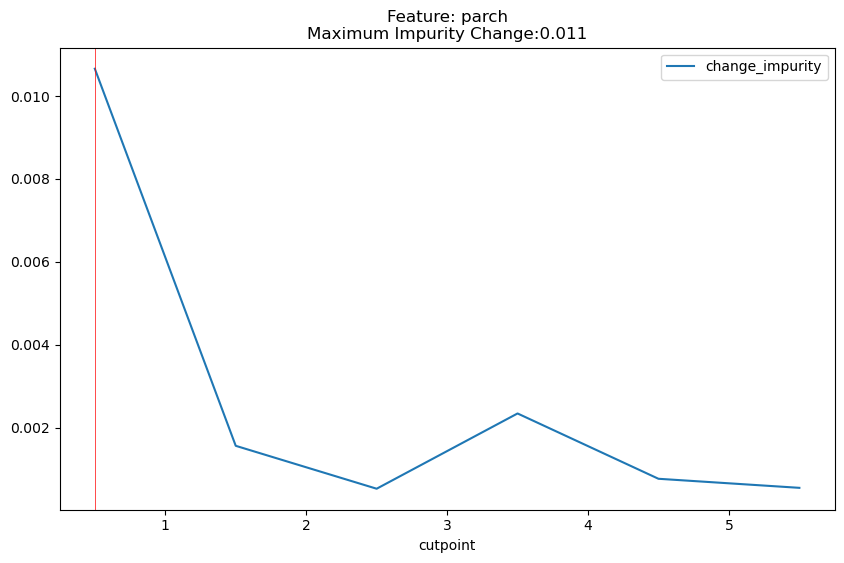

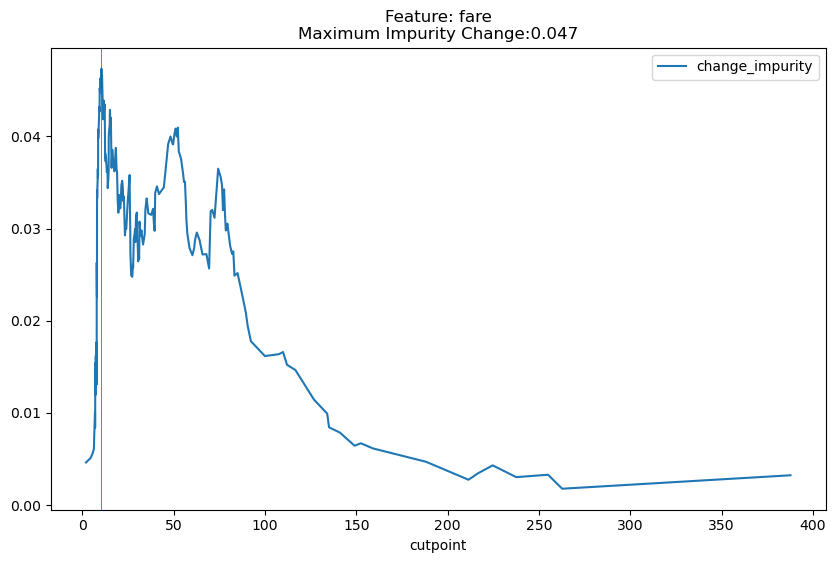

In [37]:
for feat in root_total_cost_by_feature.keys():
    ax = root_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'change_impurity', figsize= (10, 6))
    ax.axvline(x= root_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    best_cost_calculated= np.round(root_total_cost_by_feature[feat]["data"].change_impurity.max(), 3)
    ax.set_title(f'Feature: {feat}\nMaximum Impurity Change:{best_cost_calculated}')

### Left Node

In [38]:
left_feature, left_cut, left_left_avg, left_right_avg, left_total_cost_by_feature, left_fi = \
find_optimal_cutpoint(df_multiplefeatures[df_multiplefeatures[root_feature] < root_cut])

Parent Node Impurity: 0.5709141922481396
Parent Node Size (N_t): 314

Optimal Separation with feature fare and cut point 48.2
Left Node Size (N_l): 225
Left Node Impurity: 0.6395504757704886
Right Node Size (N_r): 89
Right Node Impurity: 0.21632400270956859


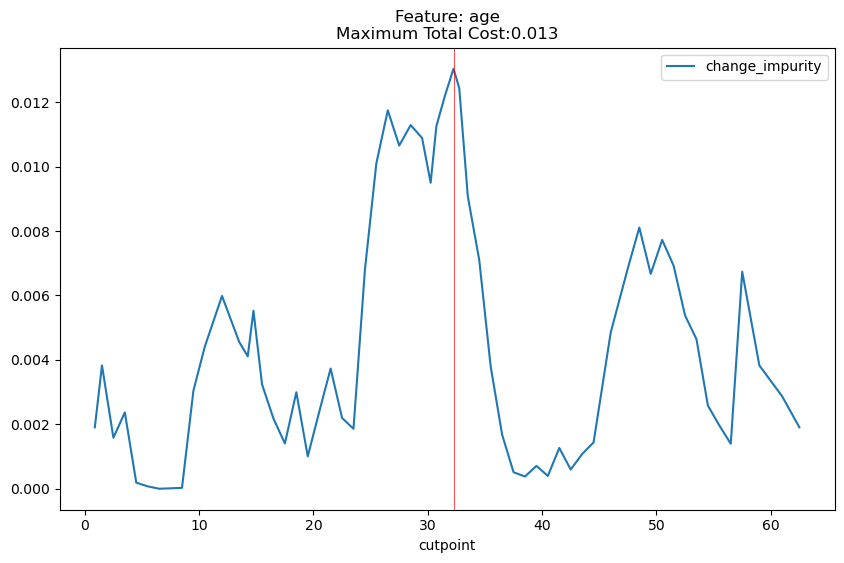

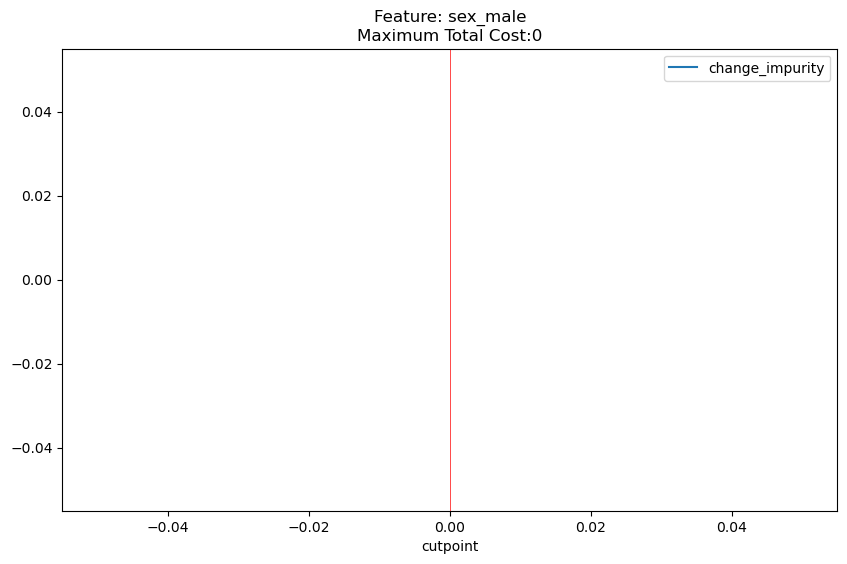

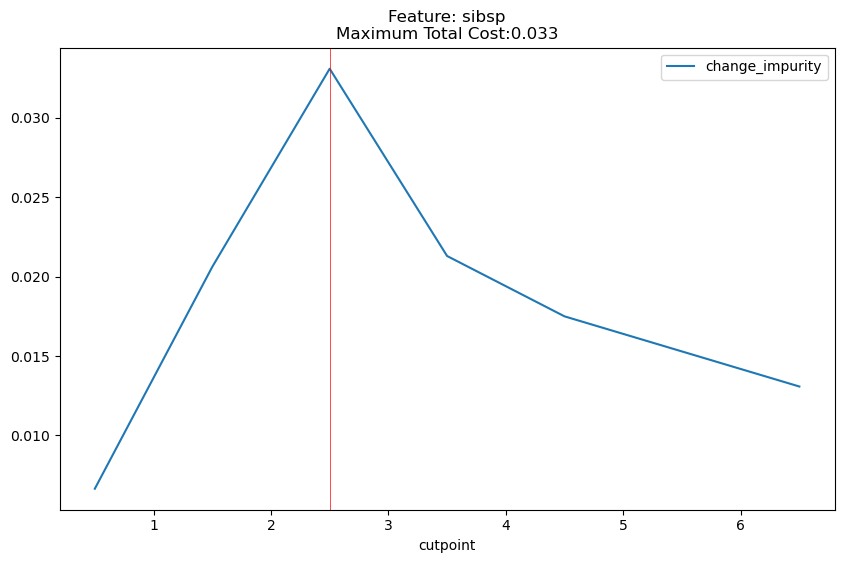

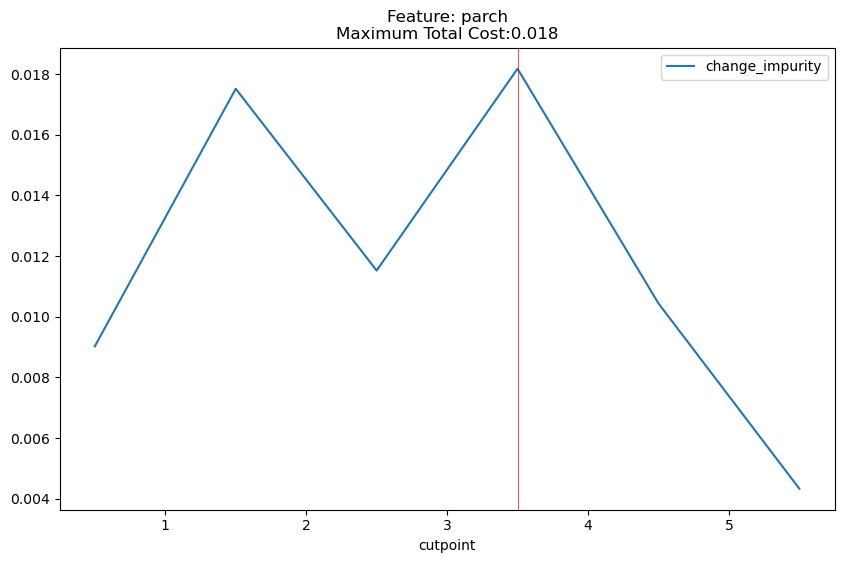

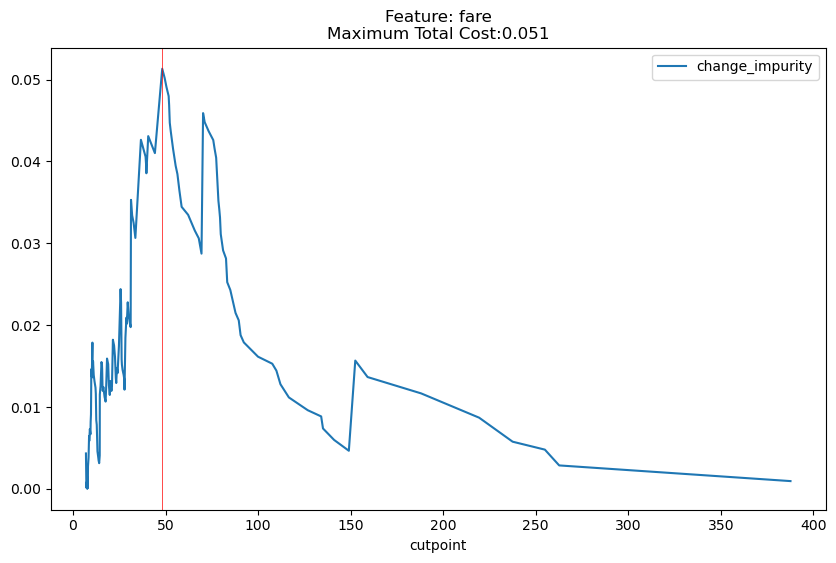

In [78]:
for feat in left_total_cost_by_feature.keys():
    ax = left_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'change_impurity', figsize= (10, 6))
    ax.axvline(x= left_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    best_cost_calculated= np.round(left_total_cost_by_feature[feat]["data"].change_impurity.max(), 3)
    ax.set_title(f'Feature: {feat}\nMaximum Total Cost:{best_cost_calculated}')

### Right Node

In [39]:
right_feature, right_cut, right_left_avg, right_right_avg, right_total_cost_by_feature, right_fi = \
find_optimal_cutpoint(df_multiplefeatures[df_multiplefeatures[root_feature] >= root_cut])

Parent Node Impurity: 0.4846358858279689
Parent Node Size (N_t): 577

Optimal Separation with feature fare and cut point 26.26875
Left Node Size (N_l): 415
Left Node Impurity: 0.3866156733086722
Right Node Size (N_r): 162
Right Node Impurity: 0.6407073816817059


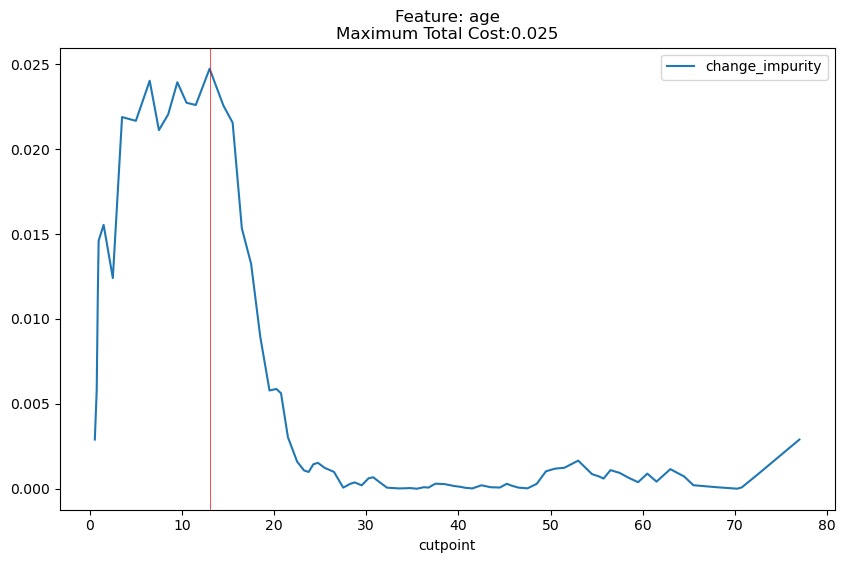

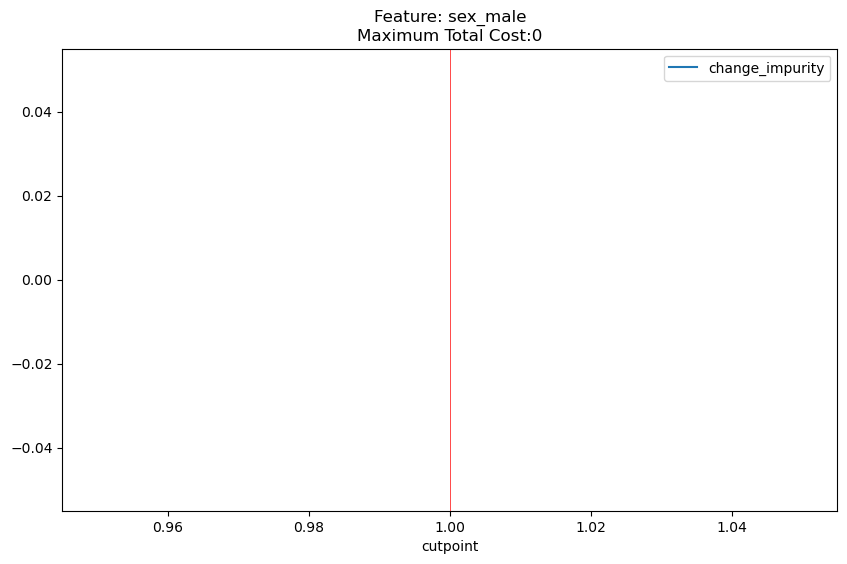

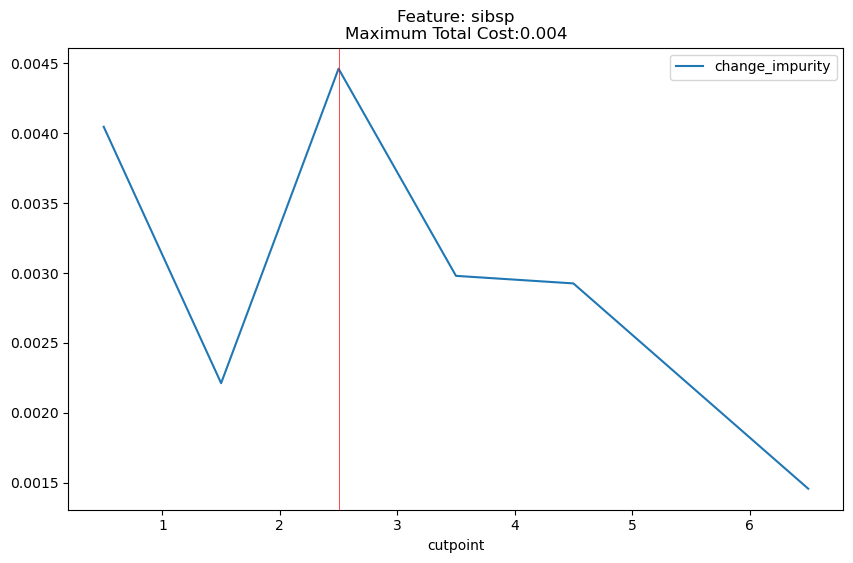

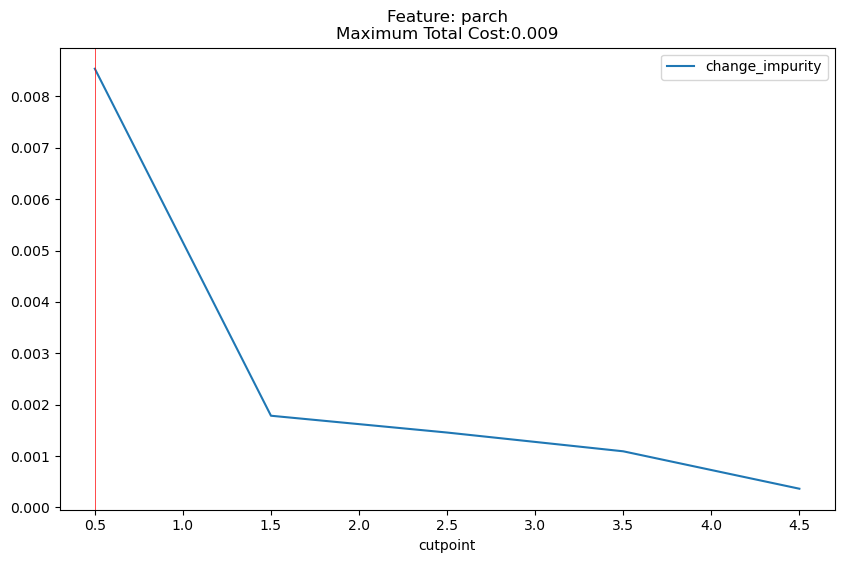

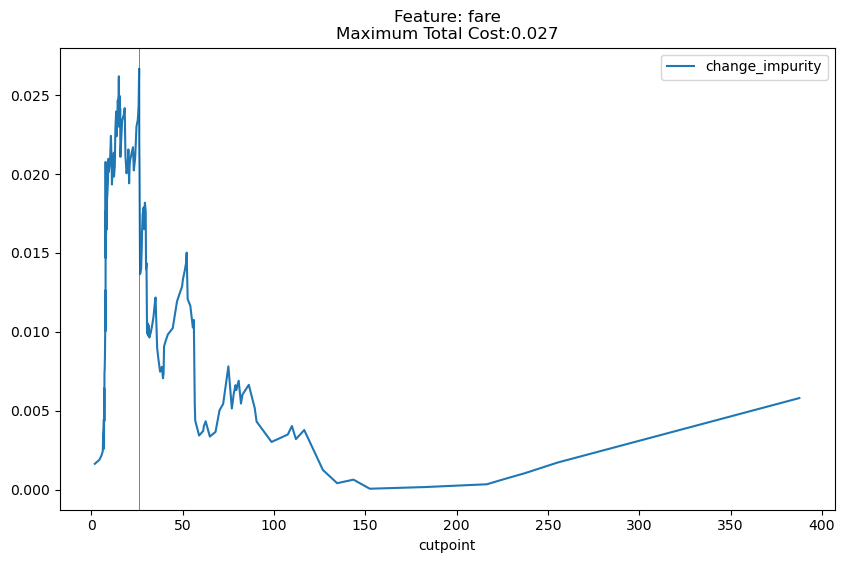

In [40]:
for feat in right_total_cost_by_feature.keys():
    ax = right_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'change_impurity', figsize= (10, 6))
    ax.axvline(x= right_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    best_cost_calculated= np.round(right_total_cost_by_feature[feat]["data"].change_impurity.max(), 3)
    ax.set_title(f'Feature: {feat}\nMaximum Total Cost:{best_cost_calculated}')

In [41]:
print(root_feature, root_cut)
print(left_feature, left_cut)
print(right_feature, right_cut)

sex_male 0.5
fare 48.2
fare 26.26875


In [42]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier(max_depth= 2, criterion= 'entropy')
dec_tree.fit(X= df_multiplefeatures[features_interest], 
             y= df_multiplefeatures.target)

sklearn_tree_detail= \
pd.DataFrame({'feature_label':dec_tree.tree_.feature,
              'feature':[features_interest[f] for f in dec_tree.tree_.feature],
              'cutpoint':dec_tree.tree_.threshold
             })


sklearn_tree_detail['feature'] = \
np.where(sklearn_tree_detail.feature_label == -2, 'LEAF', sklearn_tree_detail.feature)
sklearn_tree_detail['cutpoint'] = \
np.where(sklearn_tree_detail.feature_label == -2, np.nan, sklearn_tree_detail.cutpoint)

sklearn_tree_detail

,feature_label,feature,cutpoint
0,1,sex_male,0.500000
1,4,fare,48.200001
2,-2,LEAF,NaN
3,-2,LEAF,NaN
4,4,fare,26.268750
5,-2,LEAF,NaN
6,-2,LEAF,NaN


#### Feature Importance

In [43]:
for k, v in dict(zip(features_interest, dec_tree.feature_importances_)).items():
    print(k, v)

age 0.0
sex_male 0.8101062355673108
sibsp 0.0
parch 0.0
fare 0.1898937644326892


In [44]:
feat_imp = \
pd.DataFrame(np.vstack([root_fi, left_fi, right_fi]), 
             columns= ['opt_feat', 'fi'])
feat_imp.fi = feat_imp.fi.astype(float)

feat_imp.groupby(['opt_feat'])['fi'].sum() / feat_imp.groupby(['opt_feat'])['fi'].sum().sum()

opt_feat
fare        0.189894
sex_male    0.810106
Name: fi, dtype: float64

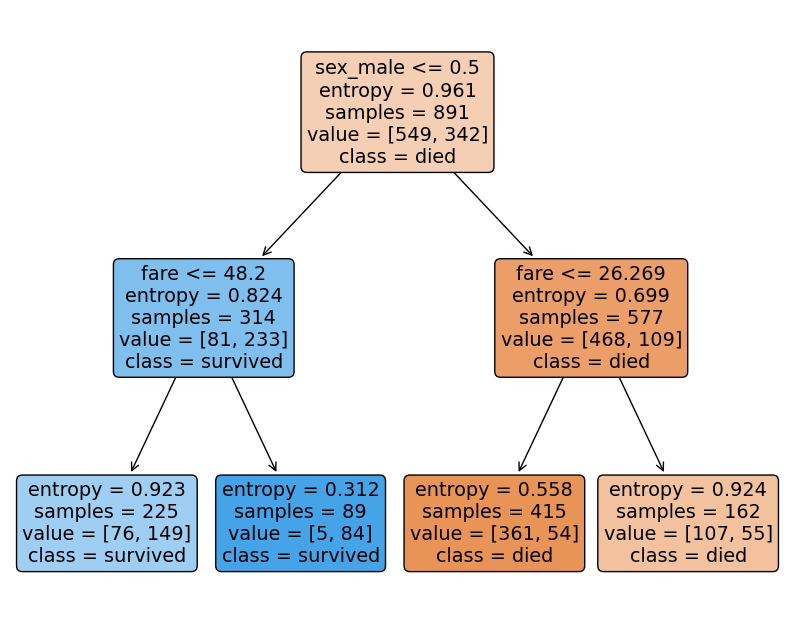

In [45]:
from sklearn import tree

plt.figure(figsize= (10, 8))
tree.plot_tree(decision_tree= dec_tree, 
               feature_names= features_interest,
               class_names= ['died', 'survived'],
               rounded= True, filled= True)
plt.show()

In [46]:
from sklearn.inspection import permutation_importance

perm_imp= \
permutation_importance(estimator= dec_tree, n_repeats= 10,
                       X= df_multiplefeatures[features_interest],
                       y= df_multiplefeatures.target)

In [47]:
perm_imp

{'importances_mean': array([0.        , 0.26150393, 0.        , 0.        , 0.        ]),
 'importances_std': array([0.        , 0.01167444, 0.        , 0.        , 0.        ]),
 'importances': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.25140292, 0.24915825, 0.25364759, 0.2671156 , 0.25364759,
         0.25589226, 0.27609428, 0.25140292, 0.27384961, 0.28282828],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]])}

In [48]:
list(zip(features_interest, perm_imp.importances_mean))

[('age', 0.0),
 ('sex_male', 0.2615039281705948),
 ('sibsp', 0.0),
 ('parch', 0.0),
 ('fare', 0.0)]